# Part 6: Self-Fulfilling Predictions & Feedback Loops

Machine learning systems do not just reflect the world — they can often shape it.

In this part of the notebook we try to understand how biased predictions can reinforce themselves. A simulation study of predictive policing is used as a concrete example. 

Two important concepts are:<sup>1</sup>

| Concept | Description |
|--------|-------------|
| **Self-Fulfilling Prediction**  | A prediction changes behavior, decisions, or resource allocation in a way that the predicted outcome becomes true — not because the prediction was accurate, but because it influenced the result. |
| **Feedback Loop**  | A cyclical process where model outputs affect behavior or data collection, which in turn feeds back into the system and reinforces future outputs. The model is increasingly confident in its own predictions, not because reality has changed, but because it shaped what was measured.|

---

## How they interact

- The two often **occur together** and **reinforce** each other.
- Difference:
  - **Self-fulfilling prediction**: usually a single causal chain
  - **Feedback loop**: iterative, with multiple cycles over time
- Both can **amplify historical inequalities** and distort the system’s objectivity.

---

## Ethical Perspective<sup>1,</sup><sup>7</sup>

Self-fulfilling predictions are ethically relevant because they **influence social reality** while maintaining an illusion of neutrality.

- They do not merely *describe* the world, they *shape* it.
- Predictions affect **how people are treated** and **how resources are allocated**.
- The line between **observation** and **intervention** becomes blurred.
  - Example: A prediction changes conditions in such a way that it becomes true — not due to accuracy, but due to its effect.
- In such cases, algorithms can create the very **evidence** that appears to confirm their correctness.

These systems often seem objective and data-driven but in reality, they can **reinforce structural inequalities**.

The feedback mechanisms are often **hidden** or **indirect**, making their impact **difficult to detect**.

> It looks like the model is predicting the future,  
> but it is actually shaping the future it claims to foresee.

**Example of a self-fulfilling prediction**:
A university predicts that a student is likely to drop out → denies financial aid → student actually drops out.

Can initiate a **feedback loop** if similar cases influence future predictions.

---

## Example: Predictive Policing

Predictive policing systems forecast:
- *Where* crime might happen
- *Who* might be involved

These predictions are based on **historical crime data**. This data reflects not just crime, but **past police presence**, strategies, and reporting behavior.

---

## Place-Based Systems (e.g. PredPol)<sup>2</sup>

| Step | Description |
|------|-------------|
| 1. | Model analyzes past crime data (location, time, type). |
| 2. | Prediction: Area X has a high crime risk. |
| 3. | Police increase patrols in Area X. |
| 4. | More incidents are detected in Area X. |
| 5. | New data used for retraining → confirms original prediction. |

**Self-fulfilling prediction**:
Step 3 — the prediction leads to increased patrols, which increases the likelihood of detecting crime, making the prediction come true.

**Feedback loop**: 
Steps 4–5 — new data from increased patrols feeds back into the system, reinforcing and repeating the prediction over time.

---

## Person-Based Systems (e.g. Strategic Subject List)<sup>2</sup>

- Use data like:
  - Social networks
  - Police interaction history
  - Commercial data
- Output: **Risk score** → influences surveillance, stops, and arrests.
- High-risk individuals are more likely to be investigated → higher chance of recording minor offenses → risk score reinforced.

---

## Ethical Issues<sup>2,</sup><sup>3</sup>

| Issue | Description |
|-------|-------------|
| **Illusion of objectivity** | Predictions seem data-driven but actually shape the outcomes. |
| **Social impact** | Reinforces stigma, stress, inequality, and may increase police violence. |
| **Lack of transparency** | Neither the public nor law enforcement may understand how scores are calculated. |
| **No accountability** | People cannot know or challenge why they are classified as “high-risk”. |

**Example:** *Beware* system in Fresno — even police couldn’t explain how threat scores were assigned.

---

## Predictive Policing Simulation

This case study demonstrates how **self-fulfilling predictions** and **feedback loops** can emerge in predictive policing systems using historical crime data. We simulate the effects of increased police presence in high-risk areas and show how this influences future model outputs. 

We use real-world data from the **Berlin Crime Atlas** published by the Berlin Police.<sup>5</sup>
The dataset contains **frequency values** for various crime categories, normalized by population to enable fair comparison between subdistricts.
For this simulation, we use a processed version that:

- Focuses on the years **2018-2023** to reflect recent trends
- Contains only **subdistrict-level data**, avoiding double-counting from higher-level aggreagations and allowing a detailed **spatial analysis** of crime patters

---

First we import the necessary libraries. Use pip install for packages you do not have.

---

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

---

## Load and Merge Data

- Load Berlin subdistrict shapefile (`LOR_2023-01-01_BZR_EPSG_25833_nur_ID.shp`) for geographic boundaries.<sup>4</sup>
- Load Berlin crime data from 2018–2023 (`HZ_2018-2023.csv`).<sup>5</sup> 
- Merge both datasets to associate crime values with spatial regions.

---

In [3]:
# Loading the shapefile - adjust to your save path
shapefile_path = r'C:\Users\lukas\Desktop\Fairness_Notebook\Data\PredictivePolicing_Study\LOR 2.0\LOR_2023-01-01_BZR_EPSG_25833_nur_ID.shp' 
geo = gpd.read_file(shapefile_path)

# Loading crime data (2018-2023) - adjust to your save path
crime_data_path = r'C:\Users\lukas\Desktop\Fairness_Notebook\Data\PredictivePolicing_Study\HZ_2018-2023.csv'
crime_df = pd.read_csv(crime_data_path)

# Merge data
geo['BZR_ID'] = geo['BZR_ID'].astype(str).str.zfill(6)
crime_df['LOR_Schluessel'] = crime_df['LOR_Schluessel'].astype(str).str.zfill(6)
berlin_crime_df = geo.merge(crime_df, left_on='BZR_ID', right_on='LOR_Schluessel')

---

## Select and Standardize Features

- Select a wide range of crime categories across six years.
- Standardize all numerical features to make clustering meaningful.
    - This ensures that categories with larger raw values do not dominate.
 
The crime types are organized into:

- **Top-level total** ('Straftaten insgesamt')
- **Intermediate categories** (e.g. 'Diebstahl insgesamt')
- **Specific offenses** (e.g. 'Fahrraddiebstahl')

To make clustering informative but not redundant, the following **selection strategy** was used:

- **Exclude** overall total and 'Kieztaten' to avoid redundant information.
- **Keep intermediate categories** (e.g. 'Sachbeschädigung') because the specific subcategories have similar spatial pattern as their parent category (e.g. 'Sachbeschädigung durch Graffiti').
- Exception: **Theft types** - here we kept the **four subcategories**, because they show different spatial patterns:
    - 'Fahrraddiebstahl' (more in central districts)
    - 'Wohnraumeinbruch' (more in peripheral  districts)
    - 'Diebstahl an/aus Kfz' (more in central districts)
    - 'Diebstahl Kraftwagen' (more in peripheral  districts)

---

In [4]:
# Select relevant features for clustering
features = ['Raub_2018', 'Raub_2019', 'Raub_2020', 'Raub_2021', 'Raub_2022', 'Raub_2023',
            'Koerperverletzungen_2018', 'Koerperverletzungen_2019', 'Koerperverletzungen_2020',
            'Koerperverletzungen_2021', 'Koerperverletzungen_2022', 'Koerperverletzungen_2023',
            'Diebstahl_Kraftwagen_2018', 'Diebstahl_Kraftwagen_2019', 'Diebstahl_Kraftwagen_2020',
            'Diebstahl_Kraftwagen_2021', 'Diebstahl_Kraftwagen_2022', 'Diebstahl_Kraftwagen_2023',
            'Diebstahl_an/aus_Kfz_2018', 'Diebstahl_an/aus_Kfz_2019', 'Diebstahl_an/aus_Kfz_2020',
            'Diebstahl_an/aus_Kfz_2021', 'Diebstahl_an/aus_Kfz_2022', 'Diebstahl_an/aus_Kfz_2023',
            'Fahrraddiebstahl_2018', 'Fahrraddiebstahl_2019', 'Fahrraddiebstahl_2020', 'Fahrraddiebstahl_2021',
            'Fahrraddiebstahl_2022', 'Fahrraddiebstahl_2023', 'Wohnraumeinbruch_2018', 'Wohnraumeinbruch_2019',
            'Wohnraumeinbruch_2020', 'Wohnraumeinbruch_2021', 'Wohnraumeinbruch_2022', 'Wohnraumeinbruch_2023',
            'Branddelikte_2018', 'Branddelikte_2019', 'Branddelikte_2020', 'Branddelikte_2021', 'Branddelikte_2022',
            'Branddelikte_2023', 'Sachbeschaedigung_2018', 'Sachbeschaedigung_2019', 'Sachbeschaedigung_2020',
            'Sachbeschaedigung_2021', 'Sachbeschaedigung_2022', 'Sachbeschaedigung_2023', 'Rauschgiftdelikte_2018',
            'Rauschgiftdelikte_2019', 'Rauschgiftdelikte_2020', 'Rauschgiftdelikte_2021', 'Rauschgiftdelikte_2022',
            'Rauschgiftdelikte_2023']

for feature in features:
    berlin_crime_df[feature] = berlin_crime_df[feature].replace(',', '', regex=True).astype(float)

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(berlin_crime_df[features])

---

## Initial Clustering

- Use KMeans to identify **4 crime pattern clusters** across all subdistricts.
- Sort clusters based on total crime volume.
- Assign each cluster a color:
  - 🔴 Red = highest total crime
  - 🟠 Orange = high
  - 🟡 Yellow = medium
  - 🟢 Green = low

---

In [5]:
# KMeans-Clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=20)
berlin_crime_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Sort cluster and assign colors
cluster_means = berlin_crime_df.groupby('Cluster')[features].mean()
cluster_means['Total_Crime'] = cluster_means.sum(axis=1)

cluster_order = cluster_means.sort_values('Total_Crime', ascending=False).index.tolist()
colors = ['red', 'orange', 'yellow', 'green']
color_map = dict(zip(cluster_order, colors))
berlin_crime_df['Color'] = berlin_crime_df['Cluster'].map(color_map)

---

## Visualize Initial Risk Clusters

- Display all subdistricts colored by their initial crime cluster.
- These clusters represent the model’s **first prediction** of risk levels.

> In real-world predictive policing, such predictions could guide increased patrols.

#### Reflection:
*Where do you expect the high-risk clusters to be located - in central or peripheral districts?*

---

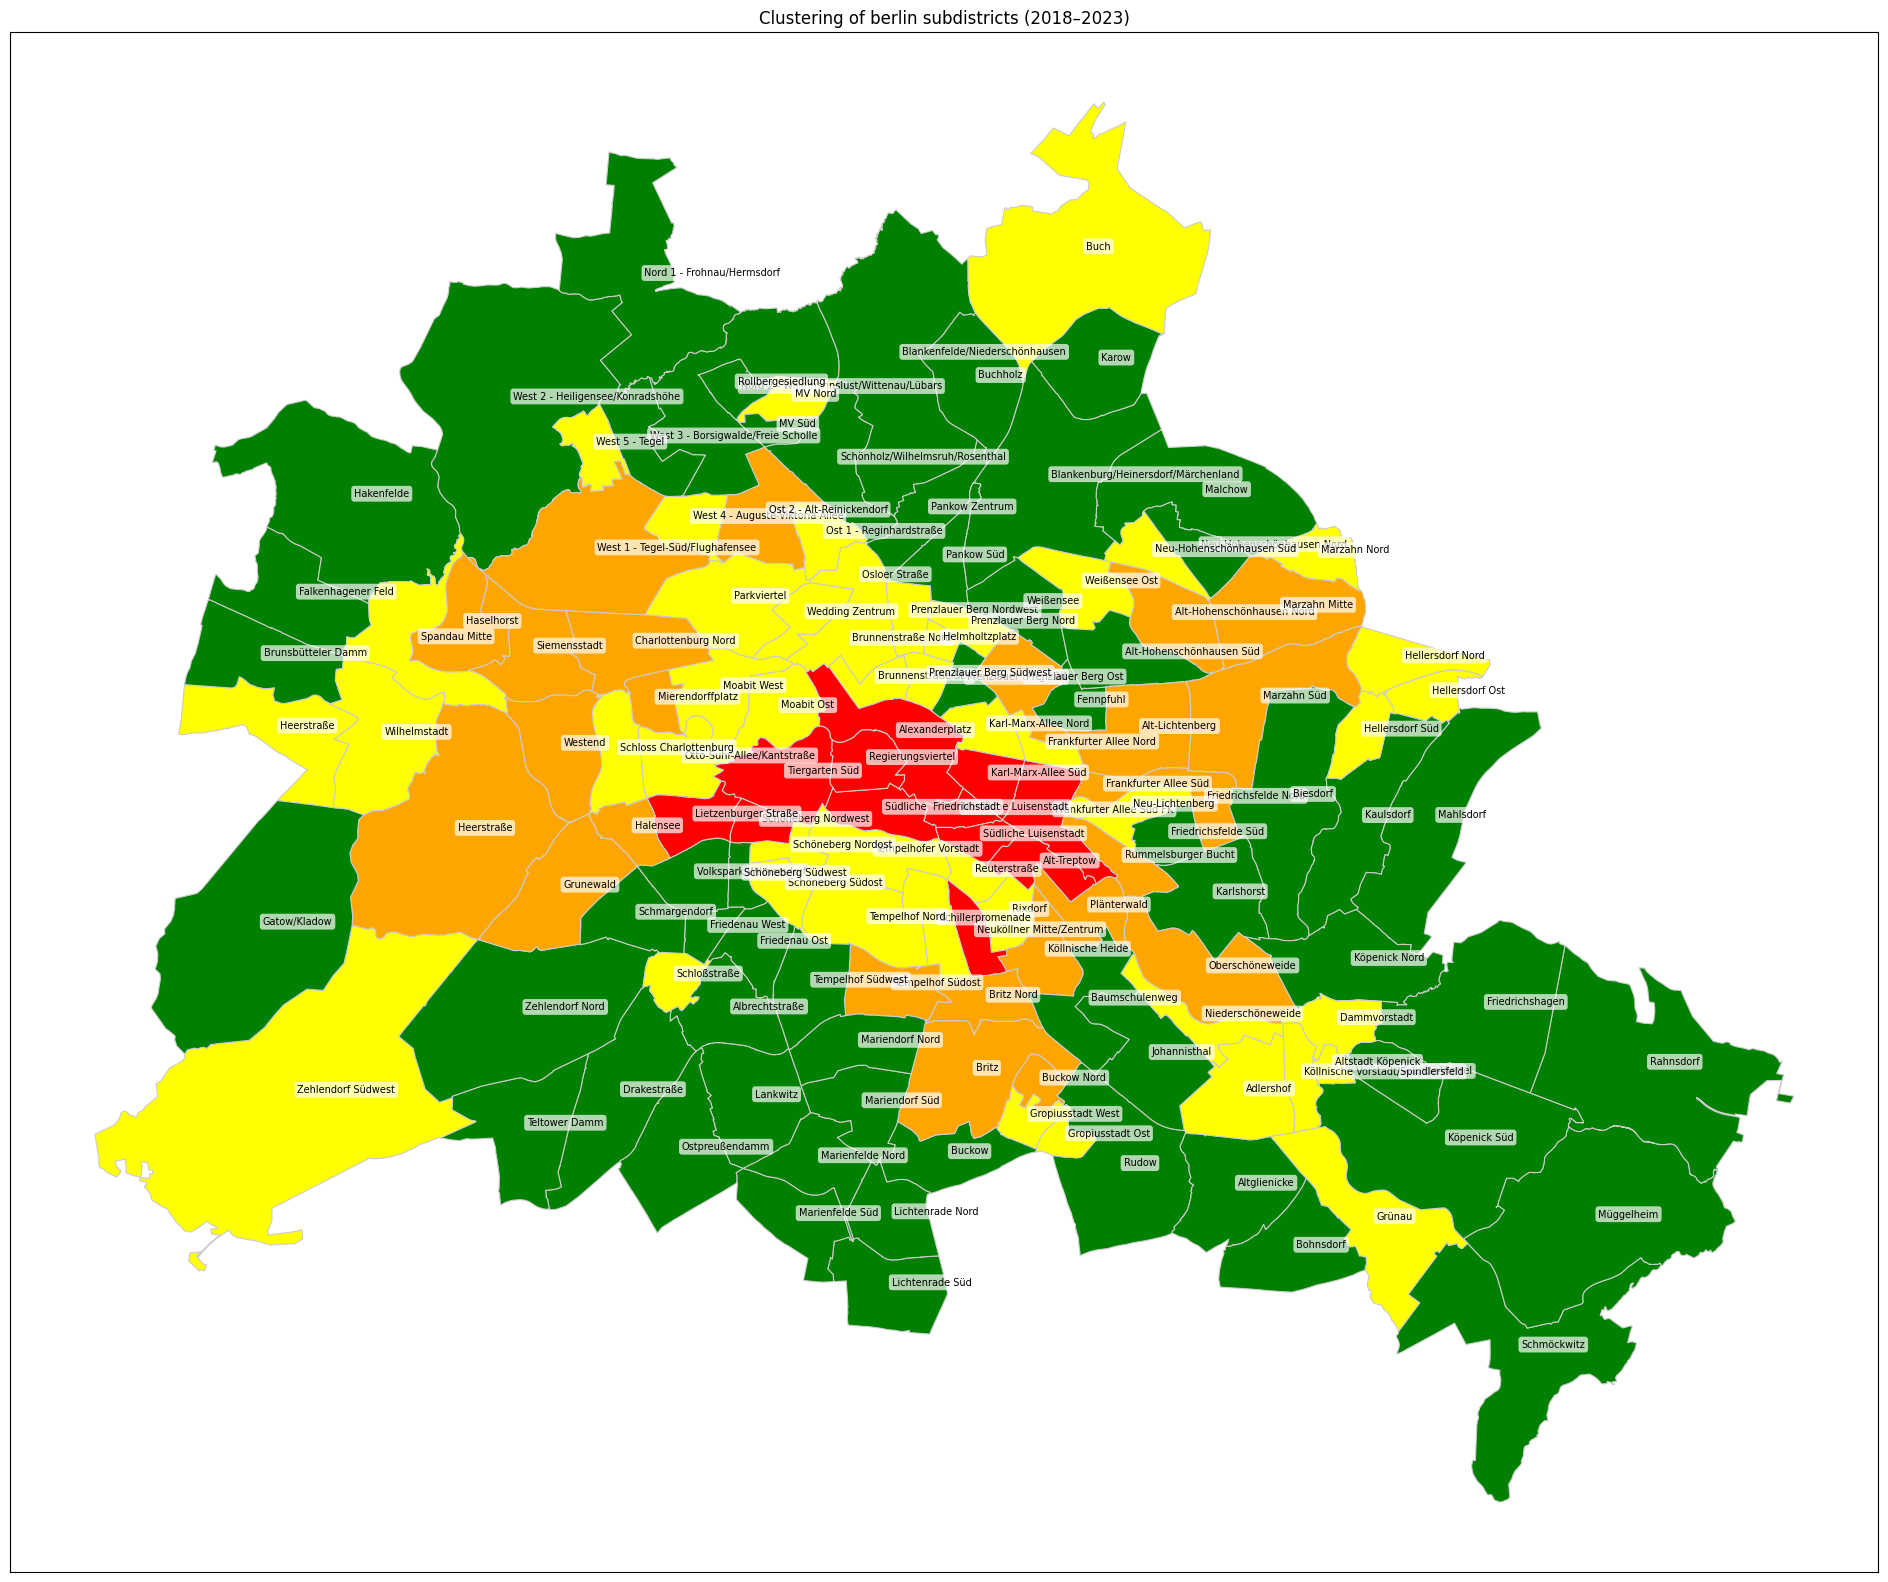

In [6]:
# Visualize the clusters (2018-2023)
fig, ax = plt.subplots(1, 1, figsize=(25, 20))
berlin_crime_df.plot(color=berlin_crime_df['Color'], linewidth=0.8, ax=ax, edgecolor='0.8')

# Show subdistrict names
for idx, row in berlin_crime_df.iterrows():
    centroid = row['geometry'].centroid
    ax.annotate(
        row['Bezeichnung'],
        xy=(centroid.x, centroid.y),
        xytext=(2, 2), # Slightly of center for less overlapping 
        textcoords='offset points',
        fontsize=7,
        color='black',
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.7),
    )

# Remove axis labels and ticks
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])

plt.title('Clustering of berlin subdistricts (2018–2023)')
plt.show()

---

### Interpretation 

As expected, the **highest-risk clusters** are concentrated in **central districts** like Kreuzberg, Mitte, and Friedrichshain.

These areas have higher rates of offenses such as **bicycle theft, drug-related crime, assault**, and **robbery**.

In contrast, **lower-risk clusters** are mostly located in **peripheral areas**, where offenses like **car theft** and **burglary** are more common but at lower overall volumes.

---

## Simulate a Feedback Loop

We simulate a 5-year scenario where:

- Police allocate more resources to **high-risk clusters**.
- This leads to more crimes being discovered in these areas — **not necessarily more committed**, but more *recorded*.
- We model this as:
  - +10% annual increase in cluster 0 (highest)
  - +5% annual increase in cluster 1 (second highest)

This illustrates a **self-fulfilling prediction** that turns into a **feedback loop**.

---

In [7]:
# Copy 
features_simulated = features.copy()
berlin_crime_simulated = berlin_crime_df.copy()

# Identify clusters
hotspot_cluster = cluster_order[0]  # Cluster with highest crime rate
secondary_cluster = cluster_order[1]

# Select hotspot and secondary areas
hotspot = berlin_crime_simulated['Cluster'] == hotspot_cluster
secondary = berlin_crime_simulated['Cluster'] == secondary_cluster

# 5 years simulation (10% in cluster 0, 5% in cluster 1)
for year in range(1, 6):  # 5 years
    berlin_crime_simulated.loc[hotspot, features_simulated] *= 1.1  # 10% increase
    berlin_crime_simulated.loc[secondary, features_simulated] *= 1.05  # 5% increase

---

## Re-Clustering After Biased Data Accumulation

- Recalculate crime totals based on the adjusted numbers.
- Rerun clustering with the new data.
- Visualize new cluster assignments to assess the impact of biased reinforcement.

#### Reflection:
*Do you expect any differences to the initial clustering?*

---

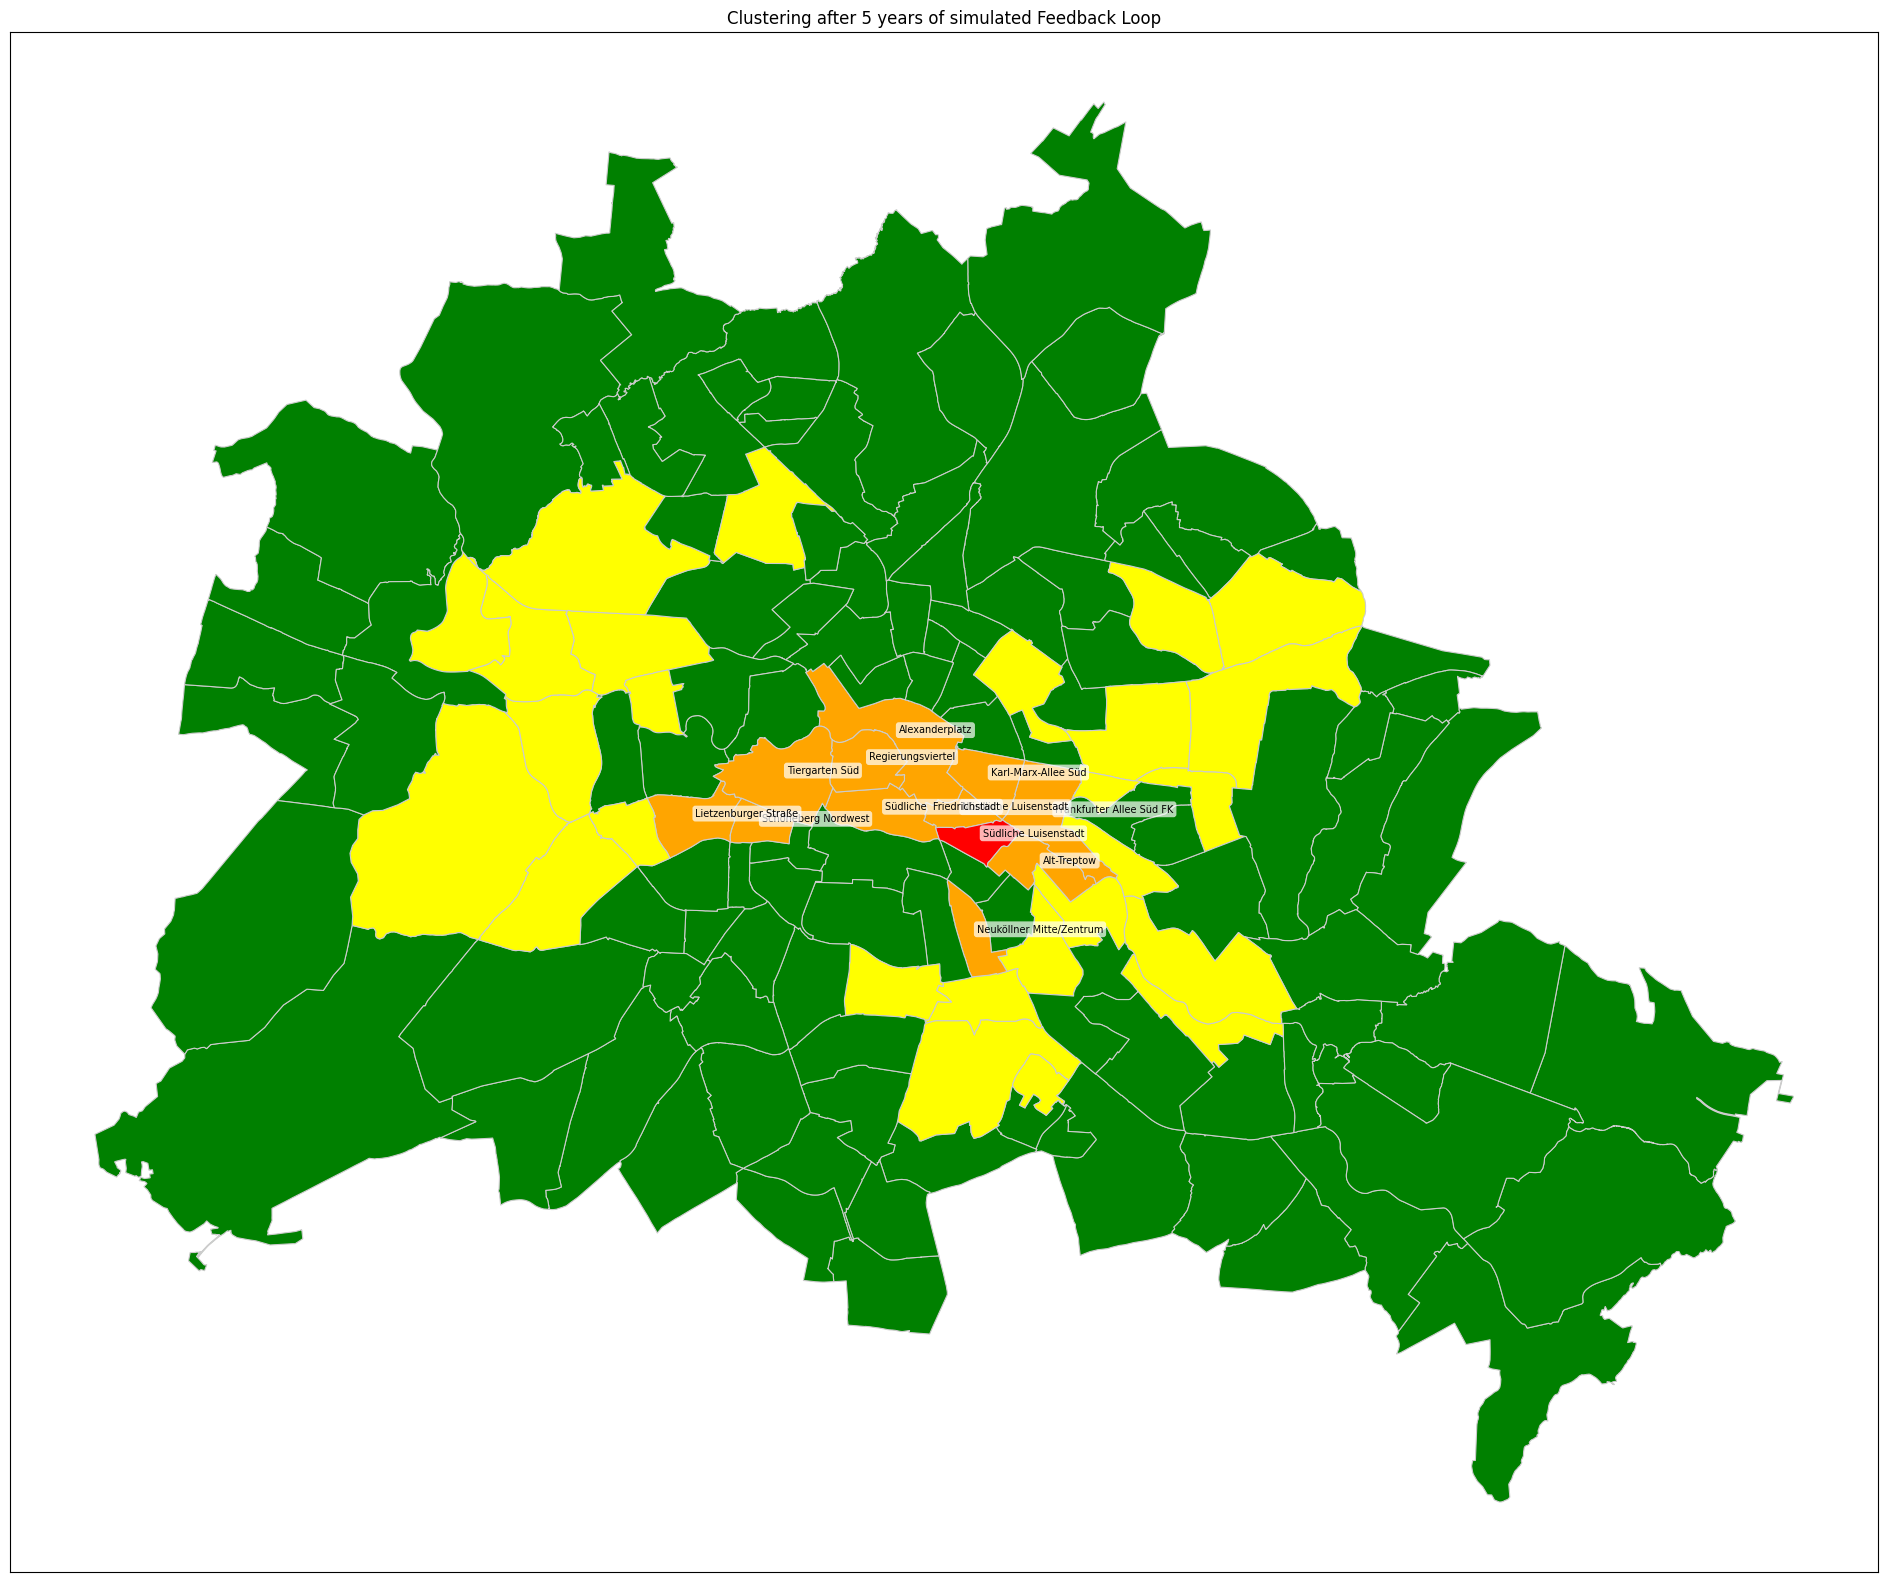

In [11]:
# Scaling and clustering with simulated values
X_scaled_simulated = scaler.fit_transform(berlin_crime_simulated[features_simulated])
berlin_crime_simulated['Cluster_Sim'] = kmeans.fit_predict(X_scaled_simulated)

# Sort and assign colors
cluster_means_simulated = berlin_crime_simulated.groupby('Cluster_Sim')[features_simulated].mean()
cluster_means_simulated['Total_Crime'] = cluster_means_simulated.sum(axis=1)
cluster_order_simulated = cluster_means_simulated.sort_values('Total_Crime', ascending=False).index.tolist()
color_map_simulated = dict(zip(cluster_order_simulated, colors))
berlin_crime_simulated['Color_Sim'] = berlin_crime_simulated['Cluster_Sim'].map(color_map_simulated)

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(25, 20))
berlin_crime_simulated.plot(color=berlin_crime_simulated['Color_Sim'], linewidth=0.8, ax=ax, edgecolor='0.8')

# Only annotate subdistricts in the two highest crime clusters
high_risk_clusters = cluster_order_simulated[:2]

# Add subdistrict names
for idx, row in berlin_crime_simulated.iterrows():
    if row['Cluster_Sim'] in high_risk_clusters:
        centroid = row['geometry'].centroid
        ax.annotate(
            row['Bezeichnung'],
            xy=(centroid.x, centroid.y),
            xytext=(2, 2),
            textcoords='offset points',
            fontsize=7,
            color='black',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.7),
    )
    
# Remove axis labels and ticks
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])

plt.title('Clustering after 5 years of simulated Feedback Loop')
plt.show()

---

### Interpretation

The new clustering map after five years of simulated predictive policing shows a more **centralized pattern** of hotspot detection.
The previously high-risk district **südliche Luisenstadt** in Kreuzberg remains red, while sourrounding areas in Friedrichshain and Mitte shift from red/orange to orange/yellow. Peripheral areas are now all green. 

This does not reflect an **actual decline** in crime elsewhere. It is the result of **biased data collection**. The intensified focus on high-risk areas leads to more detected incidents, which reinforces their classification. Over time, this creates a **feedback loop** that amplifies the model's inital assumption.

What began as a prediction turns into a **self-fulfilling prediction**. The model learns that the same areas stay dangerous, not because more crimes are committed, but because more crimes are found there. 

---

### Ethical Implications<sup>2</sup>

- What seems like data-driven **objectivity** can be the **result of the model influencing its own input**.
- This creates **self-fulfilling predictions**: after initial clustering → more police presence in hotspots → more detected crime → stronger risk signals → even more presence.
- The resulting **feedback loop** does not reflect actual crime, but a distorted version of it.
- This can **amplify social inequality** and lead to **over-policing** of already marginalized communities.
- As shown by Ensign et al. (2017), these feedback effects cannot be solved by adding more data — only by **correcting for model bias**, e.g. by down-weighting discovered incidents.<sup>6</sup>
- Without correction, such systems risk misleading decision-makers while appearing **neutral**.
- **Transparency, accountability**, and **critical evaluation** are essential in the design and evaluation of predictive models.

---

This example has shown how predictive models can unintentionally shape the very data they rely on. But feedback loops and self-fulfilling predictions are only one example of **many fairness challenges** in machine learning.
In the next section, we will explore why **achieving fairness is so difficult** in practice and what strategies can help us move toward more responsible ML systems.

---

### Quiz

**1. True or False:**
Feedback loops in predictive systems can cause the model's predictions to become less accurate over time.
1. [ ] True
2. [ ] False

**2. What is a key risk of predictive policing systems influenced by feedback loops?**
*(Select one option)*

1. [ ] Misallocation of resources and distorted crime patterns
2. [ ] Data privacy violations only
3. [ ] Focus is too wide
4. [ ] Better crime prediction in low-risk areas

**3. Which of these interventions could help mitigate feedback loops in predictive systems?**
*(Select one option)*

1. [ ] Increasing model complexity
2. [ ] Down-weighting discovered incidents during training
3. [ ] Ignoring high-risk areas in future predictions
4. [ ] Collecting more data of the same type

---

#### Sources: 
1. Barocas et al., 2023
2. Robinson & Koepke, 2016
3. Lum & Isaac, 2016
4. Amt für Statistik Berlin-Brandenburg, 2021
5. Polizei Berlin, 2023
6. Ensign et al., 2017
7. Osoba & Welser, 2017